In [112]:
import pandas as pd
import numpy as np
from scipy import stats

import pandas_datareader as pdr
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import log

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [113]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

In [114]:
yf.pdr_override()

# For time stamps
from datetime import datetime

In [115]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Download historical stock data for Apple (AAPL)
apple_data = yf.download('AAPL', start, end)

# Display the last 10 rows of the Apple stock data
print(apple_data.tail(10))



[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-21  175.070007  176.130005  173.740005  175.839996  175.839996   
2023-08-22  177.059998  177.679993  176.250000  177.229996  177.229996   
2023-08-23  178.520004  181.550003  178.330002  181.119995  181.119995   
2023-08-24  180.669998  181.100006  176.009995  176.380005  176.380005   
2023-08-25  177.380005  179.149994  175.820007  178.610001  178.610001   
2023-08-28  180.089996  180.589996  178.550003  180.190002  180.190002   
2023-08-29  179.699997  184.899994  179.500000  184.119995  184.119995   
2023-08-30  184.940002  187.850006  184.740005  187.649994  187.649994   
2023-08-31  187.839996  189.119995  187.479996  187.869995  187.869995   
2023-09-01  189.490005  189.919998  188.279999  189.460007  189.460007   

              Volume  
Date               

In [167]:
apple_data.to_csv('apple_stock_data.csv')

In [116]:
df = pd.DataFrame(apple_data)

# Display the DataFrame
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-09-04   57.102501   57.294998   56.657501   57.090000   54.677017   
2018-09-05   57.247501   57.417500   56.275002   56.717499   54.320255   
2018-09-06   56.557499   56.837502   55.325001   55.775002   53.417599   
2018-09-07   55.462502   56.342499   55.177502   55.325001   52.986618   
2018-09-10   55.237499   55.462502   54.117500   54.582500   52.275490   
...                ...         ...         ...         ...         ...   
2023-08-28  180.089996  180.589996  178.550003  180.190002  180.190002   
2023-08-29  179.699997  184.899994  179.500000  184.119995  184.119995   
2023-08-30  184.940002  187.850006  184.740005  187.649994  187.649994   
2023-08-31  187.839996  189.119995  187.479996  187.869995  187.869995   
2023-09-01  189.490005  189.919998  188.279999  189.460007  189.460007   

               Volume  
Date         

There are six columns:
High -> Highest Price of the stock for that particular date.

Low -> Lowest Price of the stock for that particular date.

Open -> Opening Price of the stock.

Close -> Closing Price of the stock.

Volume -> Total amount of Trading Activity.

AdjClose -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

In [117]:
df.shape

(1258, 6)

In [118]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

In [119]:
resumetable(df)

Dataset Shape: (1258, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Open,float64,0,1207,5.710250e+01,5.724750e+01,5.655750e+01,10.21
1,High,float64,0,1204,5.729500e+01,5.741750e+01,5.683750e+01,10.21
2,Low,float64,0,1214,5.665750e+01,5.627500e+01,5.532500e+01,10.23
3,Close,float64,0,1210,5.709000e+01,5.671750e+01,5.577500e+01,10.22
4,Adj Close,float64,0,1245,5.467702e+01,5.432026e+01,5.341760e+01,10.28
5,Volume,int64,0,1254,1.095604e+08,1.333320e+08,1.371600e+08,10.29


Analysis

<Axes: xlabel='Date'>

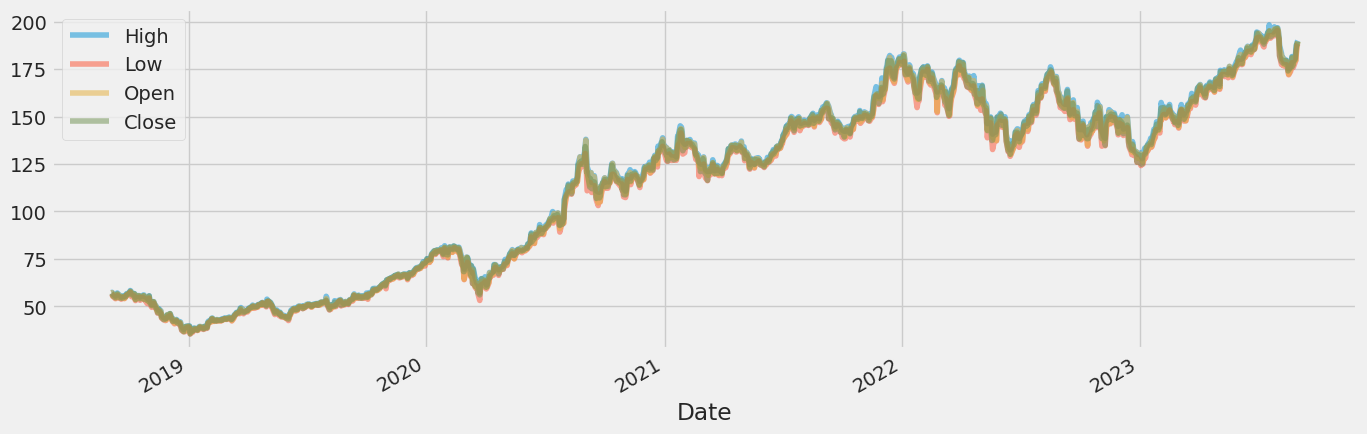

In [120]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

There are no huge variations in the Open-Close prices and the High-Low prices over the given time. These four have almost same behavior over the time. (Based on this assumption, here we will focus on one of them - 'Close' in order to build a model which could predict future values.)

We observe two huge dips in the stock prices,once around 2022 and other in March 2020(due to the Covid-19 Pandemic).




There seems to be an overall increase in stock price from over the years from 2020 to 2022

Check for stationarity

<ipython-input-121-119532e48873>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist=df.hist(ax=ax)


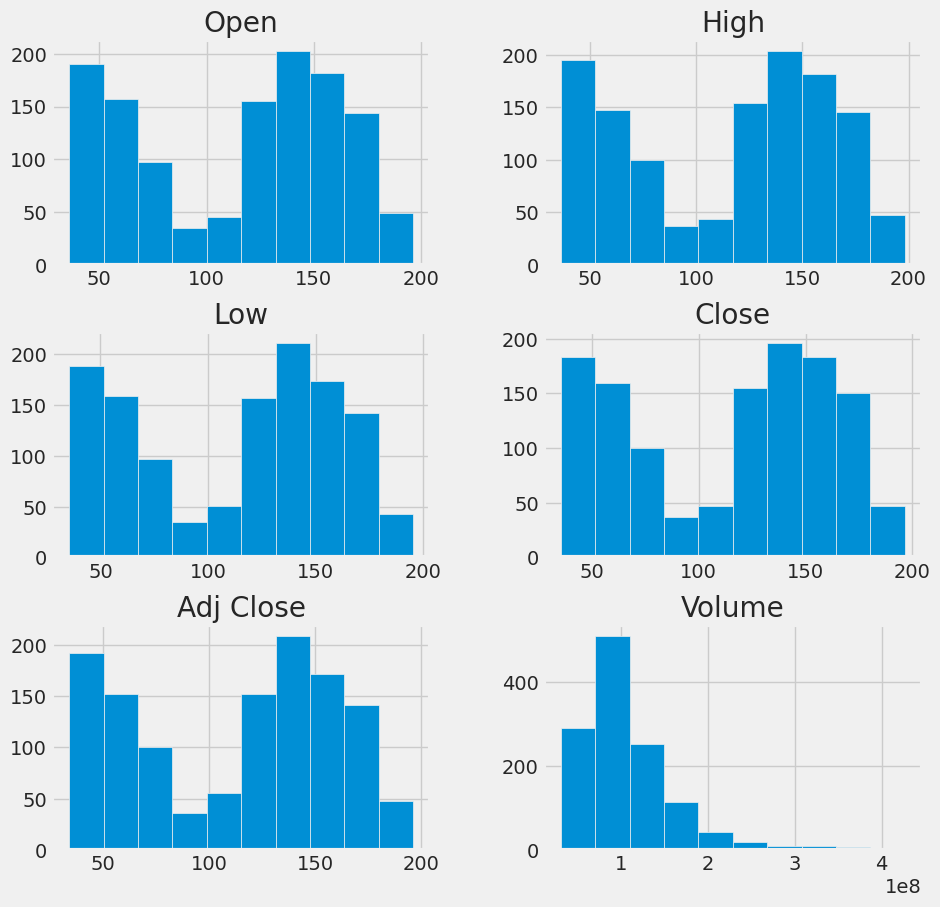

In [121]:
fig = plt.figure(figsize = (10, 10))
ax = fig.gca()
hist=df.hist(ax=ax)

The distributions are not entirely normal

Check for correlations

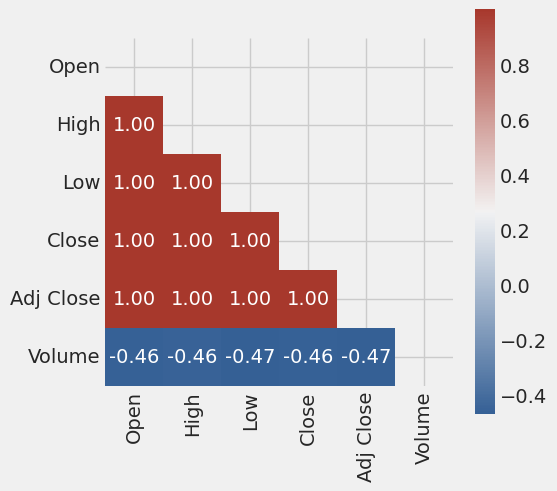

In [122]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = df.corr(method="pearson")

mask = np.triu(np.ones_like(matrix, dtype=bool))

#plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

The Relative Strength Index (RSI) calculates a ratio of the recent upward price movements to the absolute price movement. Developed by J. Welles Wilder.

The RSI calculation is RSI = 100 - 100 / ( 1 + RS ), where RS is the smoothed ratio of 'average' gains over 'average' losses. The 'averages' aren't true averages, since they're divided by the value of n and not the number of periods in which there are gains/losses.

In [123]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

(Reading database ... 120919 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link



In [124]:
df_rsi = df.copy()
df_rsi['RSI'] = talib.RSI(df_rsi['Close'])

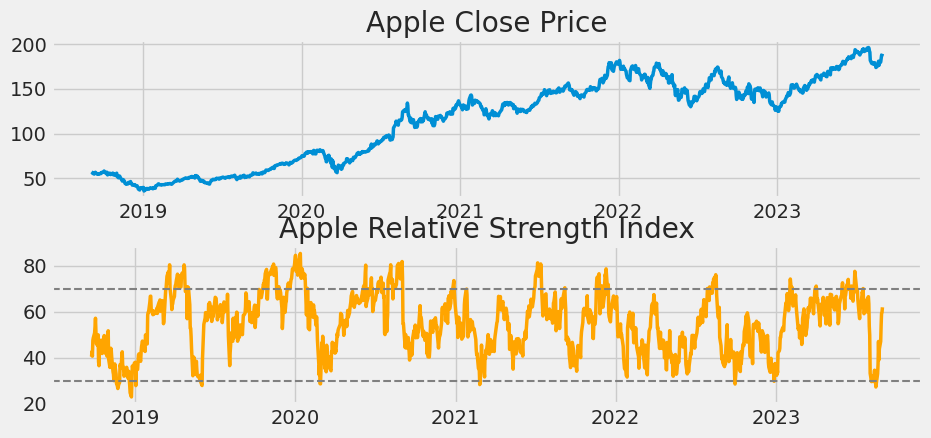

In [125]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df_rsi['Close'], linewidth = 2.5)
ax1.set_title('Apple Close Price')
ax2.plot(df_rsi['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('Apple Relative Strength Index')
plt.show()

Stocks would be bought when the RSI line goes below the bottom line, and sell when it goes above the top line

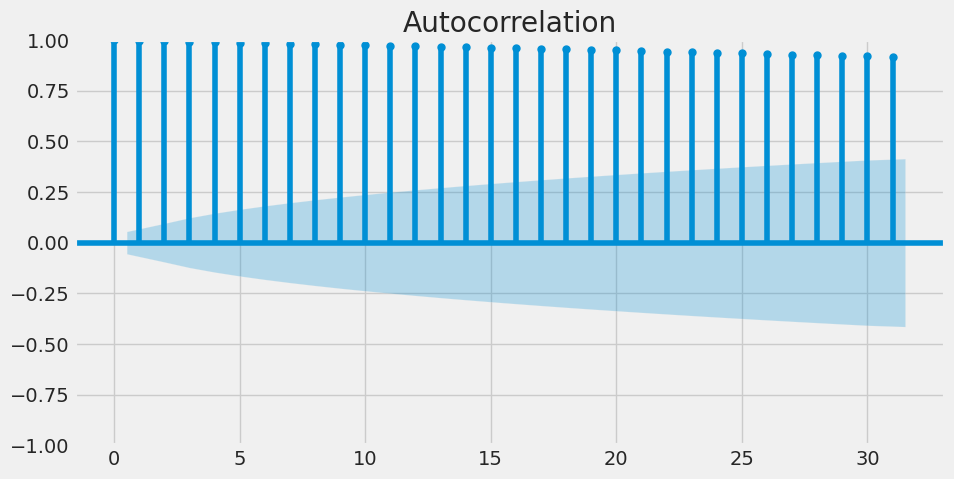

In [126]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['Close'])
print()

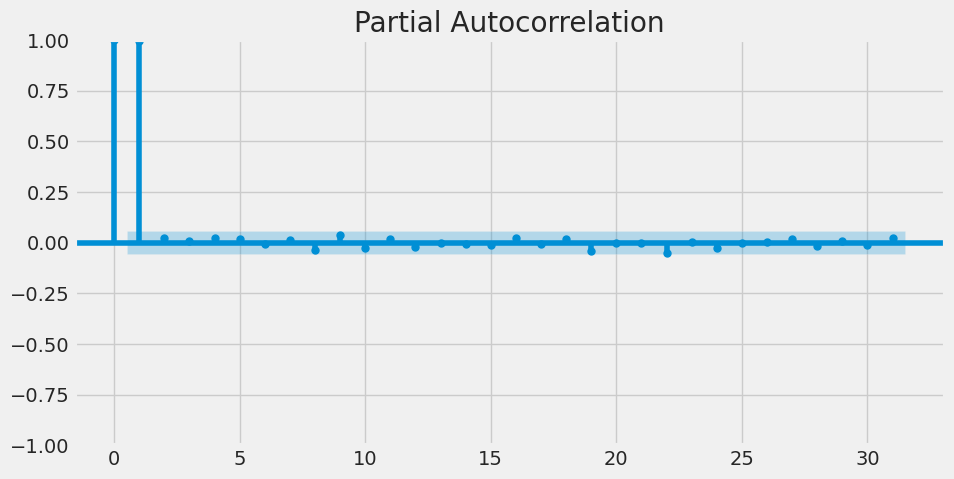

In [127]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Close'])
print()

In [128]:
test = adfuller(df['Close'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.540801
p-value: 0.883806
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


the p value is lot greater than 0.05, we fail to reject the null hypothesis of non-stationary series

Taking log transformations

In [129]:
test = adfuller(log(df['Close']))
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.790594
p-value: 0.821869
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


the given series corresponds to a non-stationary series, meaning we may need to convert this to stationary by performing some transformations.



Deep Learning models can be performed on non-stationary series to predict future values, however they take more time to train these models.

Modeling

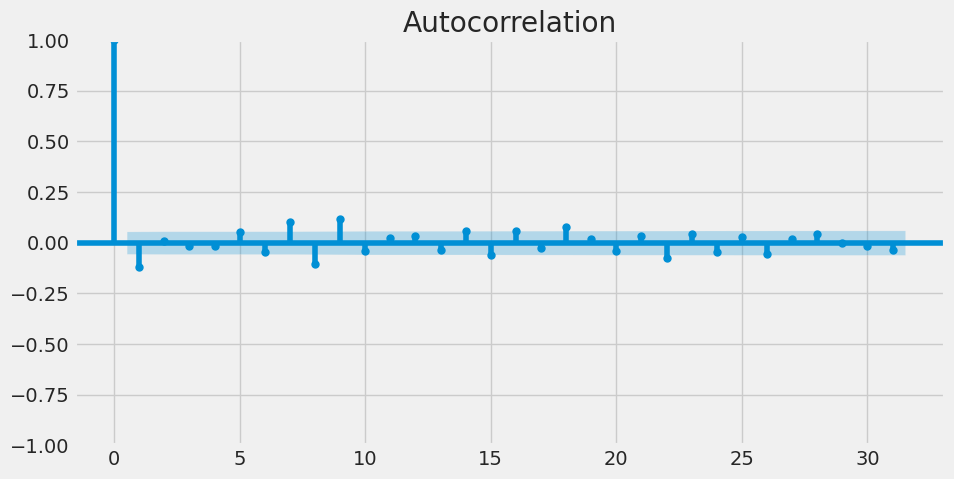

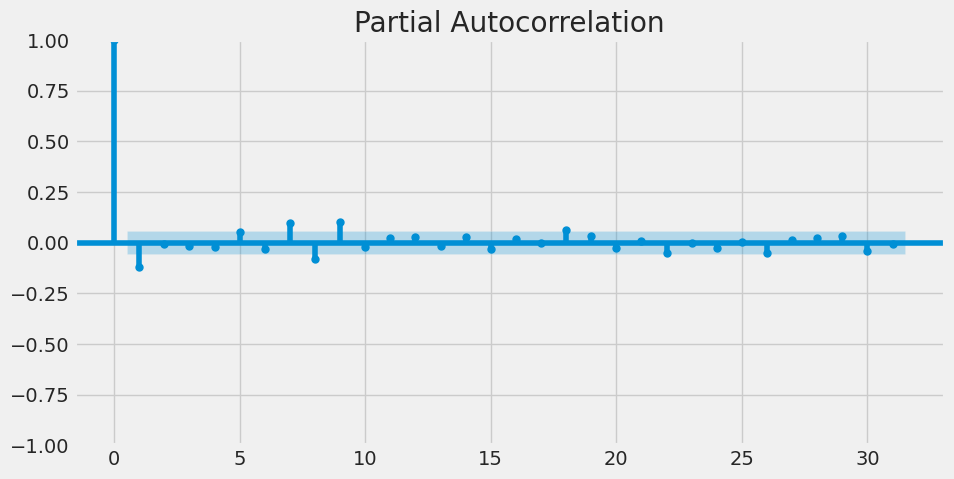

In [130]:
plt.rc("figure", figsize=(10,5))
plot_acf(log(df['Close']).diff().dropna())
plot_pacf(log(df['Close']).diff().dropna())
plt.show()

We aggregate the data from daily to monthly in order to carry out the analysis as working with daily data can be cumbersome.

Text(0.5, 1.0, 'Monthly Average Time Series Plot of Log of Closing Prices')

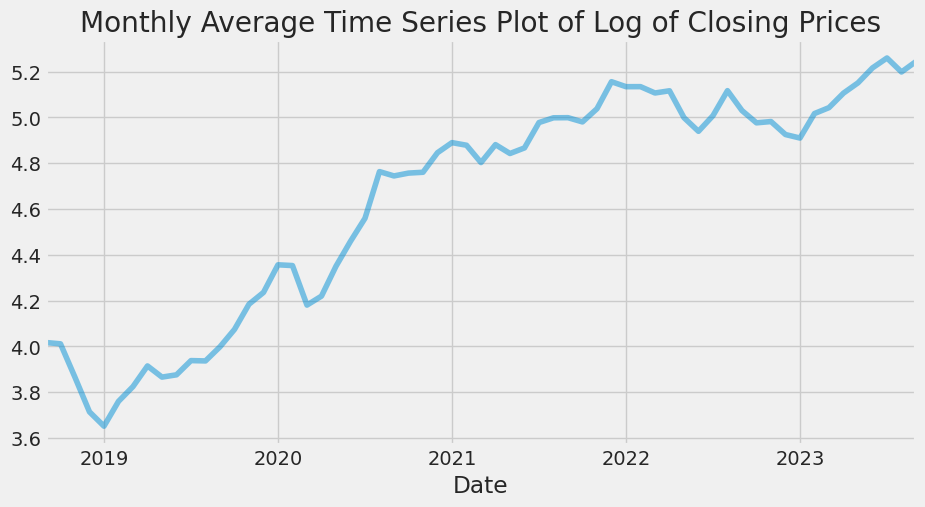

In [131]:
df_close_mon_avg = log(df['Close']).resample('MS').mean()
df_close_mon_avg.plot(figsize = (10, 5), alpha = 0.5)
plt.title('Monthly Average Time Series Plot of Log of Closing Prices')

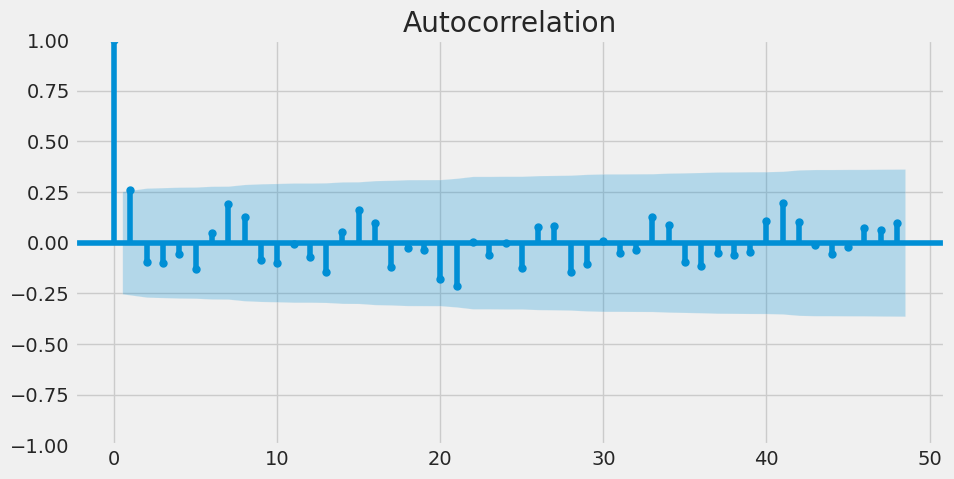

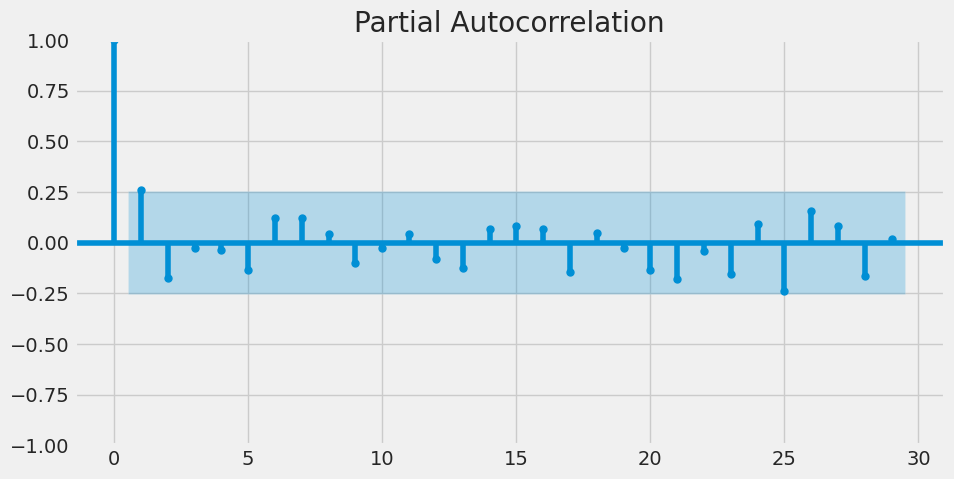

In [132]:
df_close_mon_diff = df_close_mon_avg.diff()
plt.rc("figure", figsize=(10,5))
plot_acf(df_close_mon_diff.dropna(), lags=48)
plot_pacf(df_close_mon_diff.dropna(), lags=29)
plt.show()

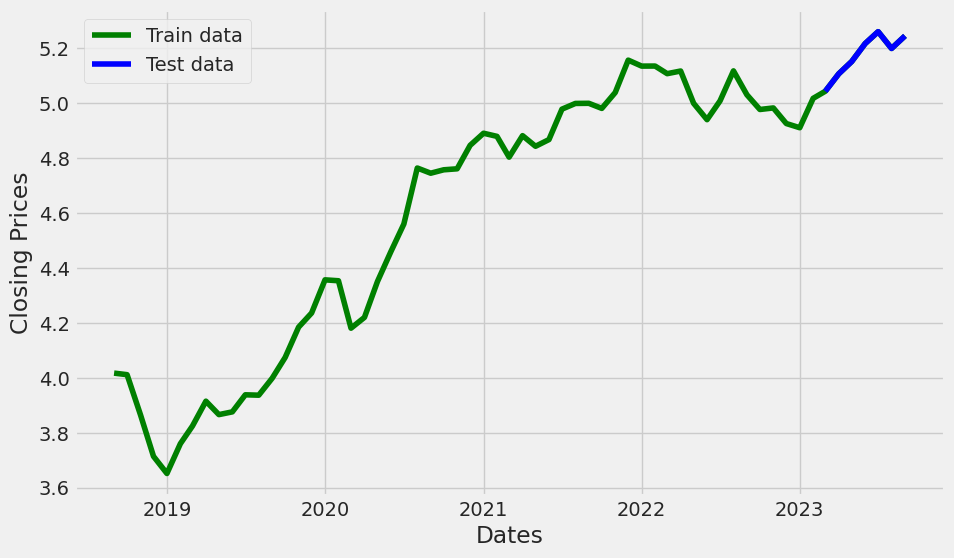

In [133]:
df_log = df_close_mon_avg
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [139]:
len(test_data)

7

In [134]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train_data,
              order=(7, 1, 2)
              )
model = mod.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   54
Model:                 ARIMA(7, 1, 2)   Log Likelihood                  64.631
Date:                Mon, 04 Sep 2023   AIC                           -109.263
Time:                        19:33:04   BIC                            -89.560
Sample:                    09-01-2018   HQIC                          -101.686
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3667      2.020      0.182      0.856      -3.592       4.325
ar.L2         -0.0222      1.831     -0.012      0.990      -3.611       3.566
ar.L3         -0.0813      0.819     -0.099      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


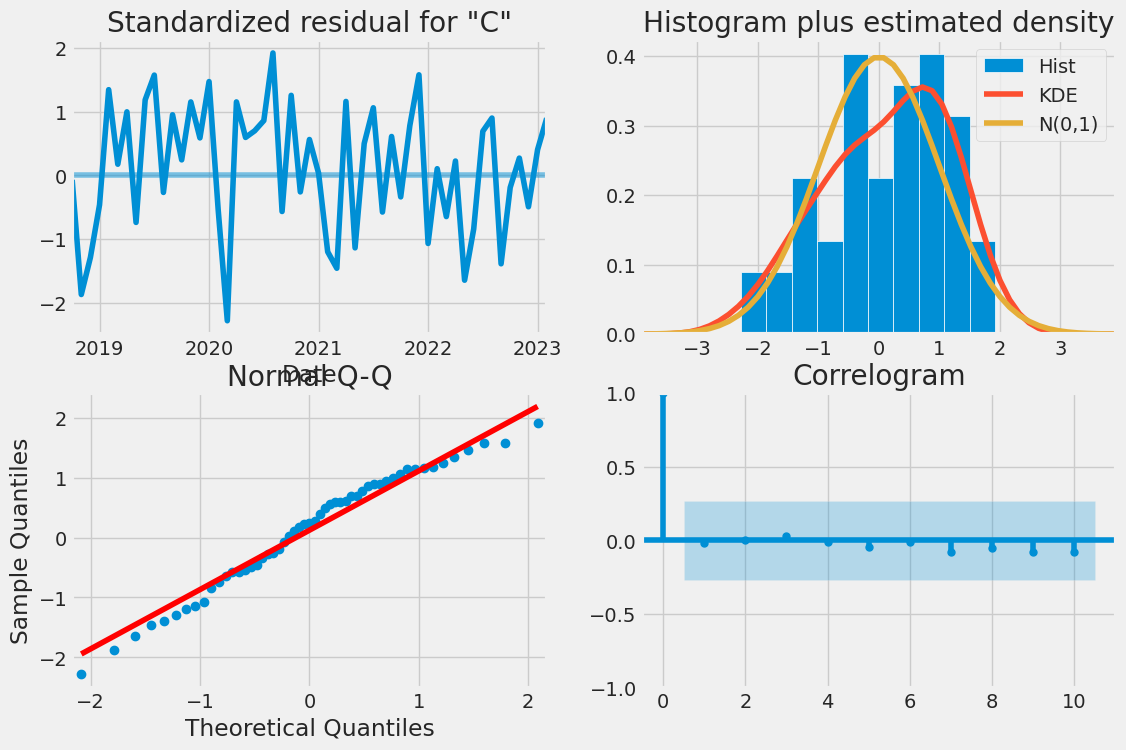

In [135]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

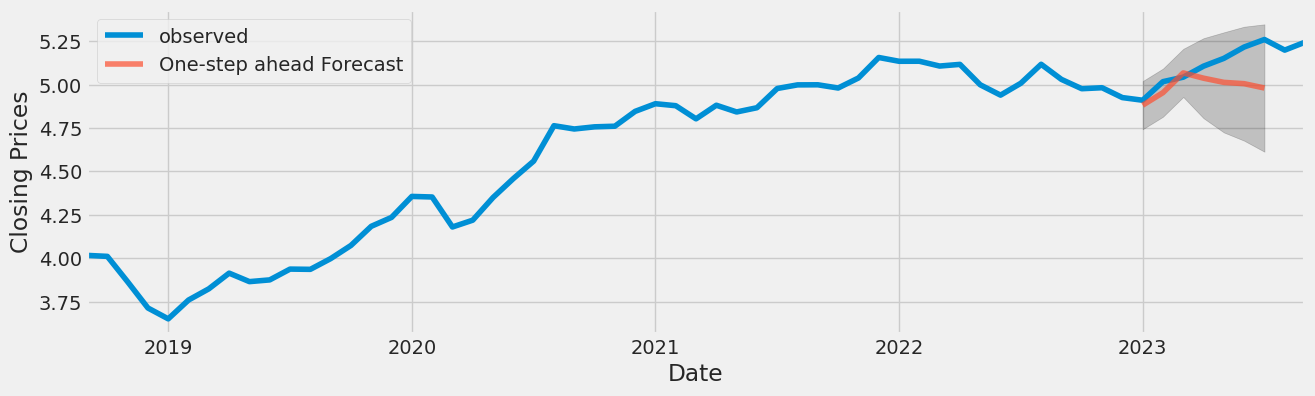

In [140]:
pred = model.get_prediction(start='2023-01-01', end='2023-07-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [141]:
y_forecasted = pred.predicted_mean
y_truth = df_log['2023-01-01':'2023-09-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.02
The Root Mean Squared Error is 0.15


In [142]:
print(len(test_data))
print(len(y_forecasted))

7
7


In [143]:
# report performance
mse = mean_squared_error(test_data, y_forecasted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_forecasted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(y_forecasted)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(y_forecasted) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 0.03664677072664148
MAE: 0.18305907575248476
RMSE: 31.40011608900655
MAPE: 0.1309614362837191


In [144]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train_data,
              order=(1, 1, 1)
              )
model = mod.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   54
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  61.446
Date:                Mon, 04 Sep 2023   AIC                           -116.893
Time:                        19:40:28   BIC                           -110.982
Sample:                    09-01-2018   HQIC                          -114.619
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0078      0.393      0.020      0.984      -0.763       0.779
ma.L1          0.3534      0.388      0.911      0.362      -0.407       1.114
sigma2         0.0057      0.001      3.987      0.0

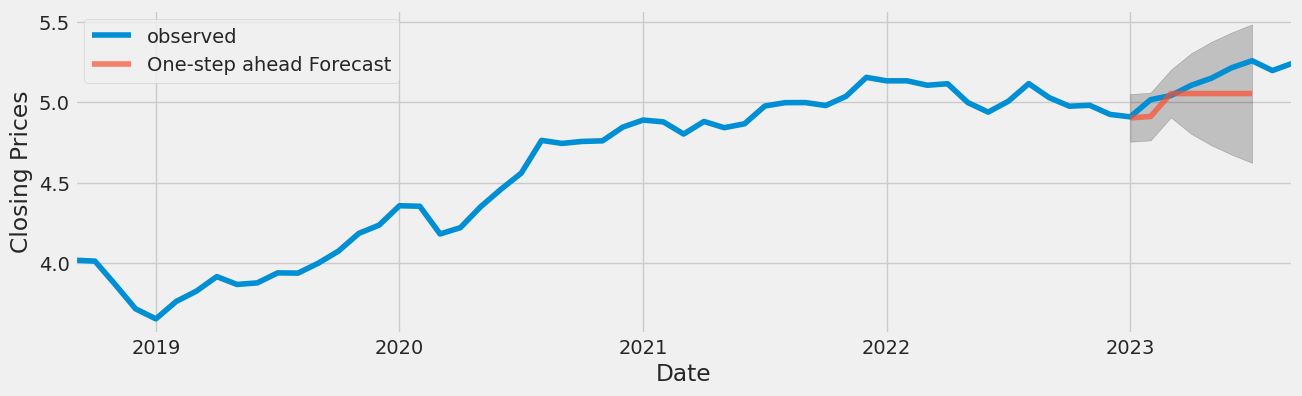

In [145]:
pred = model.get_prediction(start='2023-01-01', end='2023-07-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [146]:
y_forecasted = pred.predicted_mean
y_truth = df_log['2023-01-01':'2023-09-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.11


In [147]:
# report performance
mse = mean_squared_error(test_data, y_forecasted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_forecasted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(y_forecasted)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(y_forecasted) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 0.02720817220734984
MAE: 0.16111420865349974
RMSE: 27.183641652258764
MAPE: 0.09744716881909107


In [148]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train_data,
              order=(1, 1, 0)
              )
model = mod.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   54
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  60.877
Date:                Mon, 04 Sep 2023   AIC                           -117.753
Time:                        19:41:25   BIC                           -113.812
Sample:                    09-01-2018   HQIC                          -116.238
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3080      0.135      2.281      0.023       0.043       0.573
sigma2         0.0059      0.001      4.247      0.000       0.003       0.009
Ljung-Box (L1) (Q):                   0.04   Jarque-

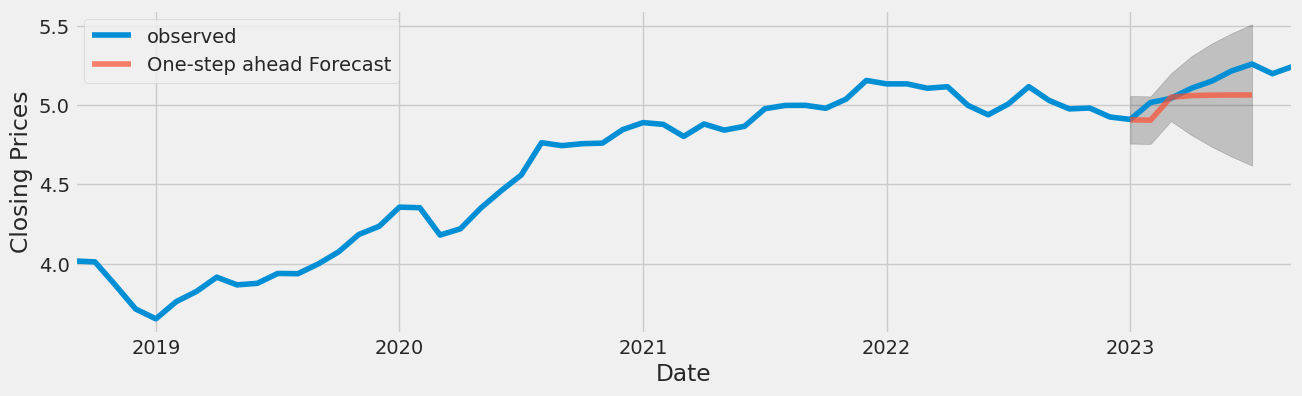

In [149]:
pred = model.get_prediction(start='2023-01-01', end='2023-07-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [150]:
y_forecasted = pred.predicted_mean
y_truth = df_log['2023-01-01':'2023-09-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.01
The Root Mean Squared Error is 0.11


In [151]:
# report performance
mse = mean_squared_error(test_data, y_forecasted)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, y_forecasted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(y_forecasted)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(y_forecasted) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 0.026029632495198914
MAE: 0.15770126572918247
RMSE: 26.560276696161125
MAPE: 0.09096620974649497


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   54
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  60.877
Date:                Mon, 04 Sep 2023   AIC                           -117.753
Time:                        19:47:51   BIC                           -113.812
Sample:                    09-01-2018   HQIC                          -116.238
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3080      0.135      2.281      0.023       0.043       0.573
sigma2         0.0059      0.001      4.247      0.000       0.003       0.009
Ljung-Box (L1) (Q):                   0.04   Jarque-

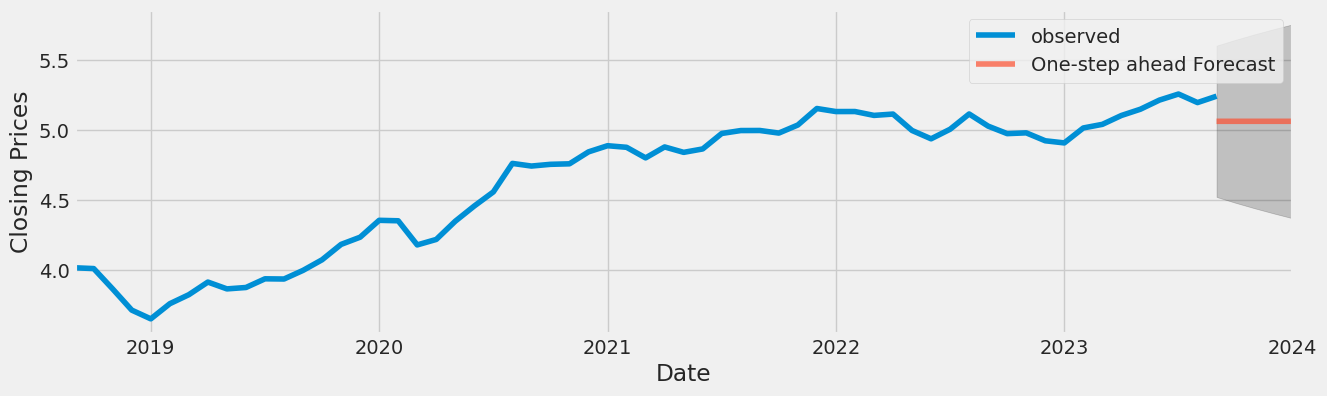

In [159]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train_data,
              order=(1, 1, 0)
              )
model = mod.fit()
print(model.summary())

pred = model.get_prediction(start='2023-09-01', end='2024-01-01', dynamic=False)
pred_ci = pred.conf_int()
ax = df_log.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Closing Prices')
plt.legend()
plt.show()

In [160]:
np.exp(pred.predicted_mean[1:]).to_frame('Close').reset_index()

,index,Close
0,2023-10-01,158.304467
1,2023-11-01,158.304889
2,2023-12-01,158.305020
3,2024-01-01,158.305060


C

In [161]:
close_series = df.Close

In [162]:
WINDOW = 10
PRED_LENGTH = int(WINDOW/2)
def get_reg_train_test(timeseries,sequence_length= 51,
                   train_size=0.9,roll_mean_window=5,
                   normalize=True,scale=False):
    # smoothen out series
    if roll_mean_window:
        timeseries = timeseries.rolling(roll_mean_window).mean().dropna()

    # create windows
    result = []
    for index in range(len(timeseries) - sequence_length):
        result.append(timeseries[index: index + sequence_length])


    # # normalize data as a variation of 0th index
    # if normalize:
    #     normalised_data = []
    #     for window in result:
    #         normalised_window = [((float(p) / float(window[0])) - 1) \
    #                                for p in window]
    #         normalised_data.append(normalised_window)
    #     result = normalised_data

    # identify train-test splits
    result = np.array(result)
    row = round(train_size * result.shape[0])

    # split train and test sets
    train = result[:int(row), :]
    test = result[int(row):, :]

    # scale data in 0-1 range
    scaler = None
    if scale:
        scaler=MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.transform(test)


    # split independent and dependent variables
    x_train = train[:, :-1]
    y_train = train[:, -1]


    x_test = test[:, :-1]
    y_test = test[:, -1]

    # Transforms for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0],
                                   x_train.shape[1],
                                   1))
    x_test = np.reshape(x_test, (x_test.shape[0],
                                 x_test.shape[1],
                                 1))

    return x_train,y_train,x_test,y_test,scaler

In [163]:
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)

print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(1122, 10, 1)
y_train shape=(1122,)
x_test shape=(125, 10, 1)
y_test shape=(125,)


LSTM model

In [164]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [168]:
from keras.layers.core import Dense, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# fix random seed for reproducibility
tf.random.set_seed(7)

df = pd.read_csv('apple_stock_data.csv',parse_dates = ['Date'], index_col = 'Date')


dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss="mse", optimizer="rmsprop")

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
1121/1121 - 19s - loss: 0.0029 - 19s/epoch - 17ms/step
Epoch 2/100
1121/1121 - 10s - loss: 0.0013 - 10s/epoch - 9ms/step
Epoch 3/100
1121/1121 - 10s - loss: 0.0011 - 10s/epoch - 9ms/step
Epoch 4/100
1121/1121 - 9s - loss: 7.2724e-04 - 9s/epoch - 8ms/step
Epoch 5/100
1121/1121 - 10s - loss: 7.2778e-04 - 10s/epoch - 9ms/step
Epoch 6/100
1121/1121 - 10s - loss: 6.0127e-04 - 10s/epoch - 9ms/step
Epoch 7/100
1121/1121 - 10s - loss: 4.4749e-04 - 10s/epoch - 9ms/step
Epoch 8/100
1121/1121 - 10s - loss: 4.6474e-04 - 10s/epoch - 9ms/step
Epoch 9/100
1121/1121 - 9s - loss: 5.3016e-04 - 9s/epoch - 8ms/step
Epoch 10/100
1121/1121 - 10s - loss: 3.9765e-04 - 10s/epoch - 9ms/step
Epoch 11/100
1121/1121 - 10s - loss: 4.9232e-04 - 10s/epoch - 9ms/step
Epoch 12/100
1121/1121 - 10s - loss: 3.8529e-04 - 10s/epoch - 9ms/step
Epoch 13/100
1121/1121 - 10s - loss: 4.0903e-04 - 10s/epoch - 9ms/step
Epoch 14/100
1121/1121 - 10s - loss: 4.1238e-04 - 10s/epoch - 9ms/step
Epoch 15/100
1121/1121 - 10s -

Train Score: 0.02 MAPE
Train Score: 2.40 RMSE
Test Score: 0.01 MAPE
Test Score: 3.18 RMSE


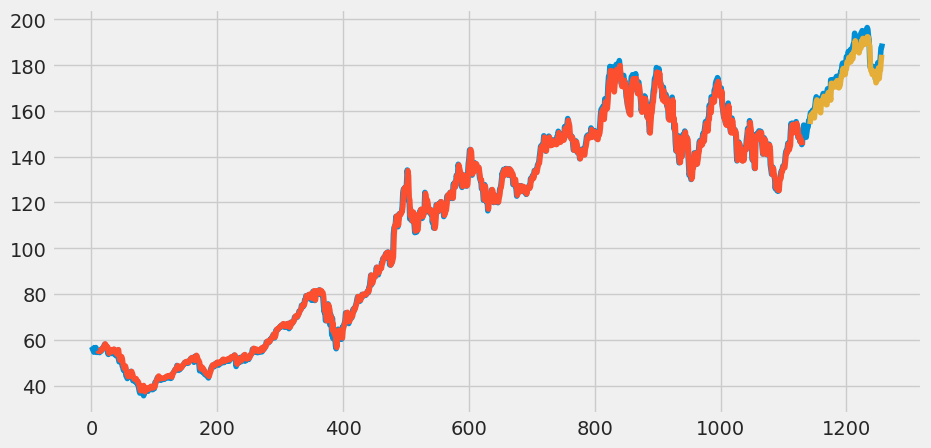

In [169]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

window size= 5


In [171]:
from keras.layers.core import Dense, Activation, Dropout

# fix random seed for reproducibility
tf.random.set_seed(7)

df = pd.read_csv('apple_stock_data.csv', parse_dates = ['Date'], index_col = 'Date')


dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, shuffle=False)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
1126/1126 - 10s - loss: 9.5662e-04 - 10s/epoch - 9ms/step
Epoch 2/100
1126/1126 - 8s - loss: 0.0018 - 8s/epoch - 7ms/step
Epoch 3/100
1126/1126 - 15s - loss: 0.0020 - 15s/epoch - 13ms/step
Epoch 4/100
1126/1126 - 11s - loss: 0.0024 - 11s/epoch - 10ms/step
Epoch 5/100
1126/1126 - 13s - loss: 0.0029 - 13s/epoch - 12ms/step
Epoch 6/100
1126/1126 - 14s - loss: 0.0032 - 14s/epoch - 12ms/step
Epoch 7/100
1126/1126 - 11s - loss: 0.0034 - 11s/epoch - 9ms/step
Epoch 8/100
1126/1126 - 9s - loss: 0.0036 - 9s/epoch - 8ms/step
Epoch 9/100
1126/1126 - 8s - loss: 0.0035 - 8s/epoch - 7ms/step
Epoch 10/100
1126/1126 - 6s - loss: 0.0033 - 6s/epoch - 5ms/step
Epoch 11/100
1126/1126 - 7s - loss: 0.0030 - 7s/epoch - 6ms/step
Epoch 12/100
1126/1126 - 6s - loss: 0.0025 - 6s/epoch - 5ms/step
Epoch 13/100
1126/1126 - 7s - loss: 0.0016 - 7s/epoch - 6ms/step
Epoch 14/100
1126/1126 - 6s - loss: 0.0014 - 6s/epoch - 5ms/step
Epoch 15/100
1126/1126 - 7s - loss: 0.0013 - 7s/epoch - 6ms/step
Epoch 16/100
1

Train Score: 0.15 MAPE
Train Score: 12.11 RMSE
Test Score: 0.07 MAPE
Test Score: 14.28 RMSE


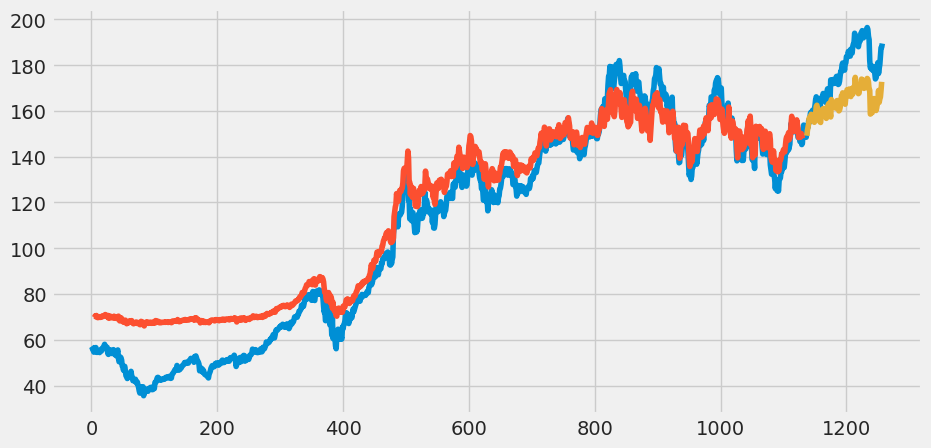

In [172]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

window size 10

In [173]:
dataset = df.Close.to_frame().values
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
# model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(100, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, shuffle=False)

# make predictions
trainPredict = model.predict(trainX, batch_size=1)
# model.reset_states()
testPredict = model.predict(testX, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
1121/1121 - 7s - loss: 8.7148e-04 - 7s/epoch - 6ms/step
Epoch 2/100
1121/1121 - 6s - loss: 0.0012 - 6s/epoch - 5ms/step
Epoch 3/100
1121/1121 - 5s - loss: 0.0013 - 5s/epoch - 4ms/step
Epoch 4/100
1121/1121 - 6s - loss: 0.0015 - 6s/epoch - 5ms/step
Epoch 5/100
1121/1121 - 5s - loss: 0.0017 - 5s/epoch - 4ms/step
Epoch 6/100
1121/1121 - 5s - loss: 0.0017 - 5s/epoch - 4ms/step
Epoch 7/100
1121/1121 - 5s - loss: 0.0016 - 5s/epoch - 5ms/step
Epoch 8/100
1121/1121 - 5s - loss: 0.0015 - 5s/epoch - 4ms/step
Epoch 9/100
1121/1121 - 6s - loss: 0.0013 - 6s/epoch - 5ms/step
Epoch 10/100
1121/1121 - 5s - loss: 0.0012 - 5s/epoch - 4ms/step
Epoch 11/100
1121/1121 - 5s - loss: 9.8380e-04 - 5s/epoch - 5ms/step
Epoch 12/100
1121/1121 - 5s - loss: 7.8131e-04 - 5s/epoch - 5ms/step
Epoch 13/100
1121/1121 - 5s - loss: 6.4233e-04 - 5s/epoch - 4ms/step
Epoch 14/100
1121/1121 - 6s - loss: 5.7146e-04 - 6s/epoch - 5ms/step
Epoch 15/100
1121/1121 - 5s - loss: 5.2842e-04 - 5s/epoch - 4ms/step
Epoch 16/1

Train Score: 0.10 MAPE
Train Score: 8.77 RMSE
Test Score: 0.07 MAPE
Test Score: 13.80 RMSE


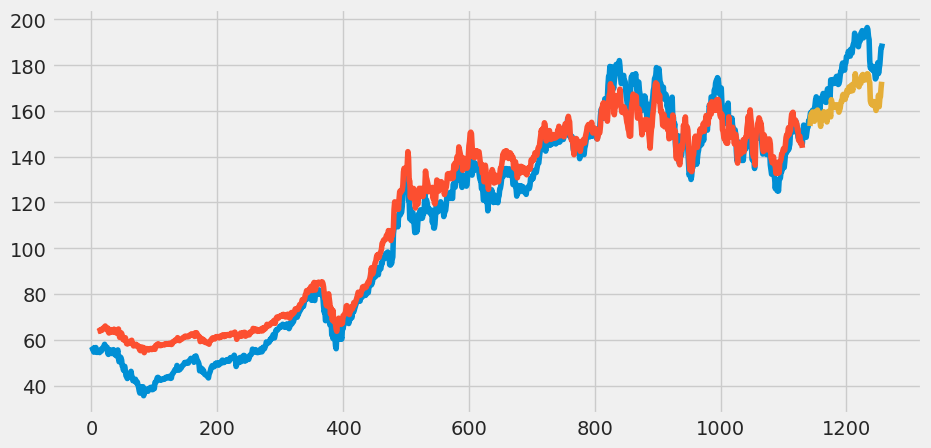

In [174]:
# calculate root mean squared error
trainScore_mape = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
trainScore_rmse = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAPE' % (trainScore_mape))
print('Train Score: %.2f RMSE' % (trainScore_rmse))

testScore_mape = mean_absolute_percentage_error(testY[0], testPredict[:,0])
testScore_rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAPE' % (testScore_mape))
print('Test Score: %.2f RMSE' % (testScore_rmse))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()